In [1]:
%matplotlib notebook
import io
import sys
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
def ridge_solve( A, d, la_array ):
    n = A.shape[1]
    w = np.zeros((n,1))
    num_lam = len(la_array)
    X = np.zeros((n, num_lam))
    for i, each_lambda in enumerate(la_array):
            w = np.linalg.inv(A.T@A+each_lambda*np.identity(n))@A.T@d
            X[:, i:i+1] = w
    return X

In [3]:
# read in the training data
trainImages = io.open('train-images.idx3-ubyte', 'rb')
trainLabels = io.open('train-labels.idx1-ubyte', 'rb')

In [4]:
magic = int.from_bytes(trainImages.read(4), byteorder='big')
if magic != 2051:
    sys.exit('Wrong magic number for train-images.idx3-ubyte')
    
magic = int.from_bytes(trainLabels.read(4), byteorder='big')
if magic != 2049:
    sys.exit('Wrong magic number for train-labels.idx3-ubyte')

imageNum = int.from_bytes(trainImages.read(4), byteorder='big')
labelNum = int.from_bytes(trainLabels.read(4), byteorder='big')

num = min(imageNum, labelNum)

# dimensions of each image
rowNum = int.from_bytes(trainImages.read(4), byteorder='big')
colNum = int.from_bytes(trainImages.read(4), byteorder='big')

images = np.zeros(num*colNum*rowNum).reshape(num, colNum*rowNum)
for i in range(num):
    for j in range(colNum*rowNum):
        images[i, j] = int.from_bytes(trainImages.read(1), byteorder='big', signed=False)

labels = np.zeros(num)
for i in range(num):
    labels[i] = int.from_bytes(trainLabels.read(1), byteorder='big', signed=False)

trainImages.close()
trainLabels.close()

In [5]:
# read in the test data
testImages = io.open('t10k-images.idx3-ubyte', 'rb')
testLabels = io.open('t10k-labels.idx1-ubyte', 'rb')

In [6]:
magicT = int.from_bytes(testImages.read(4), byteorder='big')
if magicT != 2051:
    sys.exit('Wrong magic number for t10k-images.idx3-ubyte')
    
magicT = int.from_bytes(testLabels.read(4), byteorder='big')
if magicT != 2049:
    sys.exit('Wrong magic number for t10k-labels.idx3-ubyte')

imageNumT = int.from_bytes(testImages.read(4), byteorder='big')
labelNumT = int.from_bytes(testLabels.read(4), byteorder='big')

numT = min(imageNumT, labelNumT)

# dimensions of each image
rowNumT = int.from_bytes(testImages.read(4), byteorder='big')
colNumT = int.from_bytes(testImages.read(4), byteorder='big')

imagesT = np.zeros(numT*colNumT*rowNumT).reshape(numT, colNumT*rowNumT)
for i in range(numT):
    for j in range(colNumT*rowNumT):
        imagesT[i, j] = int.from_bytes(testImages.read(1), byteorder='big', signed=False)

labelsT = np.zeros(numT)
for i in range(numT):
    labelsT[i] = int.from_bytes(testLabels.read(1), byteorder='big', signed=False)

testImages.close()
testLabels.close()

# display the image specified by index

<IPython.core.display.Javascript object>


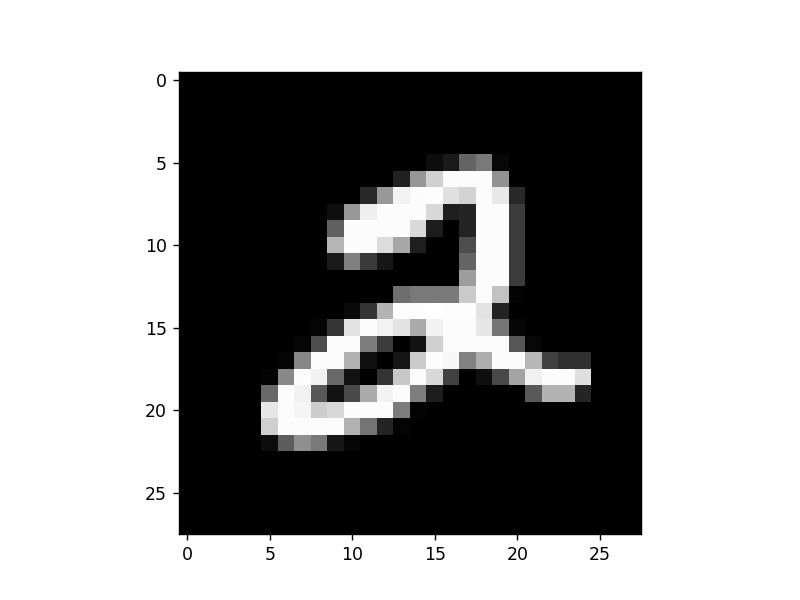

2.0


In [7]:
index = 5
sample = images[index].reshape(rowNum, colNum)

fig = plt.figure()
plt.imshow(sample, cmap='gray')
plt.show()
print(labels[index])

# show the intensity distribution of pixels

<IPython.core.display.Javascript object>


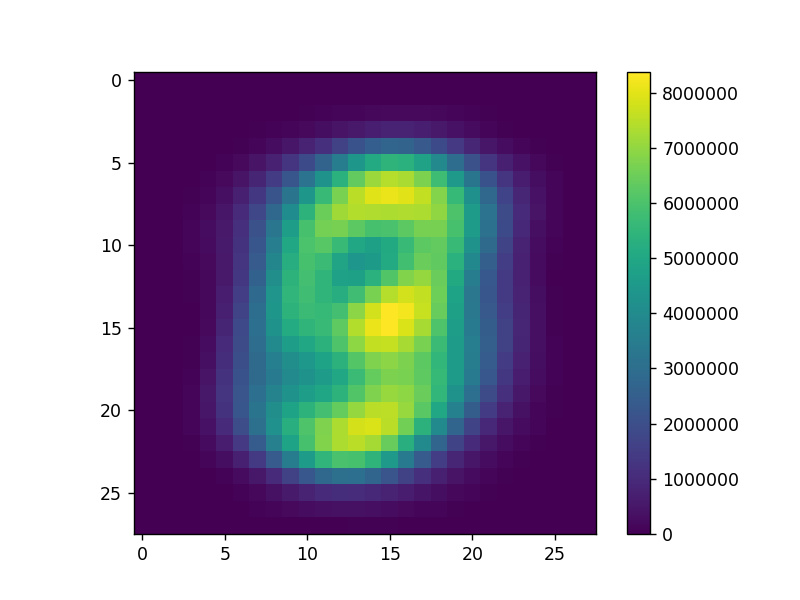

In [8]:
merge = np.zeros(rowNum*colNum)
for i in range(60000):
    merge = merge + images[i]

fig = plt.figure()
plt.imshow(merge.reshape(rowNum, colNum))
plt.colorbar()
plt.title('')
plt.show()

# SVD decomposition result

In [9]:
U, S, VT = np.linalg.svd(images, full_matrices=False)

<IPython.core.display.Javascript object>


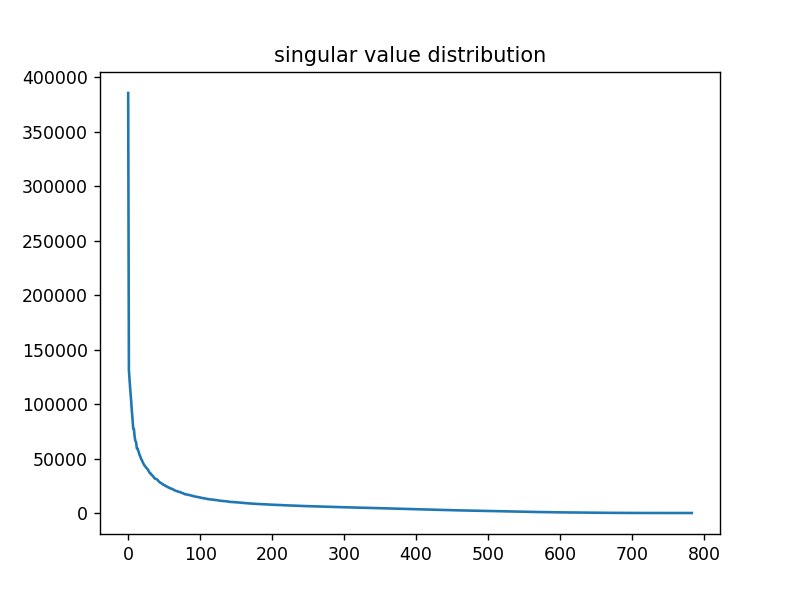

In [10]:
fig = plt.figure()
plt.plot(S)
plt.title('singular value distribution')
plt.show()

# Using $w=(A^TA+\lambda I)^{-1}A^Td$ directly with $\lambda=0.1$

In [12]:
start = time.time()
lmda = 0.1
w = np.linalg.inv(images.transpose()@images+lmda*np.identity(rowNum*colNum))@images.transpose()@labels
end = time.time()
print('Total computation time by using inversion of matrice directly: ', (end - start))

Total computation time by using inversion of matrice directly:  1.6351704597473145


# Display the distribution of weights

<IPython.core.display.Javascript object>


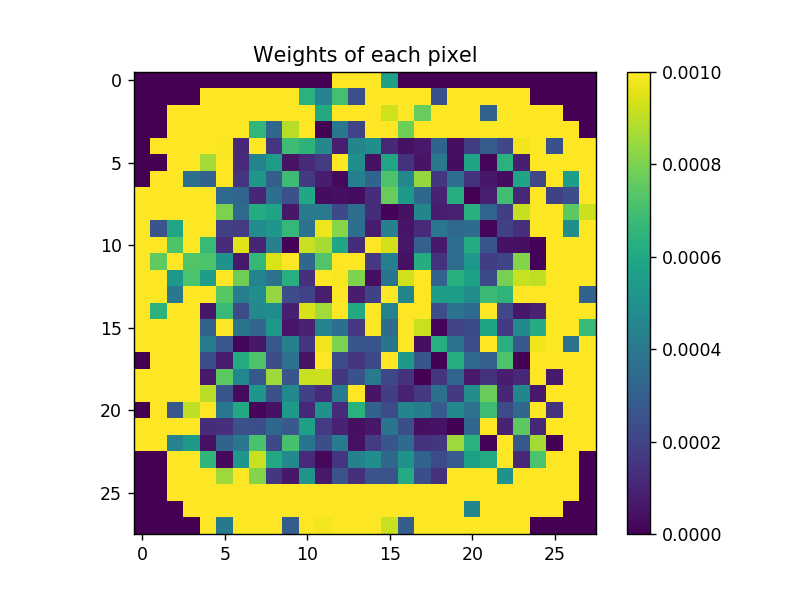

In [13]:
plt.figure()
plt.imshow(np.absolute(w.reshape(rowNum, colNum)), vmax=0.001)
plt.colorbar()
plt.title('Weights of each pixel')
plt.show()

In [14]:
labelsHat = np.around(np.clip(imagesT@w, 0, 9))
errorRate = 1 - np.sum(labelsHat == labelsT) / numT
print('error rate on the test set is: ', errorRate)

error rate on the test set is:  0.7442


# Error rate vs. number of preserved singular values

<IPython.core.display.Javascript object>


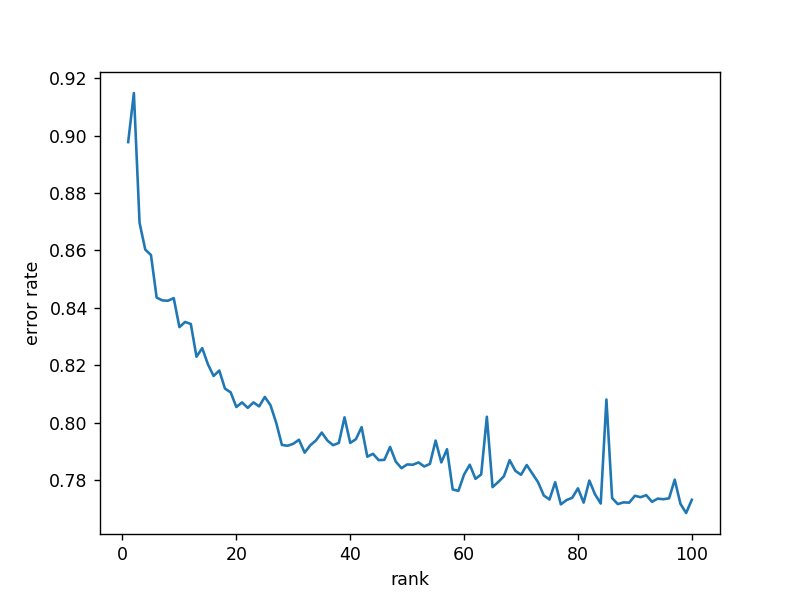

In [15]:
s = np.zeros((S.shape[0], S.shape[0]))
w = np.zeros((colNum*rowNum, 100))
errorRate = np.zeros(100)
lmda = 0.1

for i in range(100):
    s[i, i] = S[i]
    imagesReduced = U@s@VT
    w[:,i] = np.linalg.inv(imagesReduced.transpose()@imagesReduced+lmda*np.identity(rowNum*colNum))@imagesReduced.transpose()@labels
    
    labelsHat = np.around(np.clip(imagesT@w[:,i], 0, 9))
    errorRate[i] = 1 - np.sum(labelsHat == labelsT) / numT

fig = plt.figure()
plt.plot(np.arange(1,101), errorRate)
plt.xlabel('rank')
plt.ylabel('error rate')
plt.show()

# Using rank=60 approximation and tuning the parameter $\lambda=2^k, k = -4, -3, ..., 3, 4$

<IPython.core.display.Javascript object>


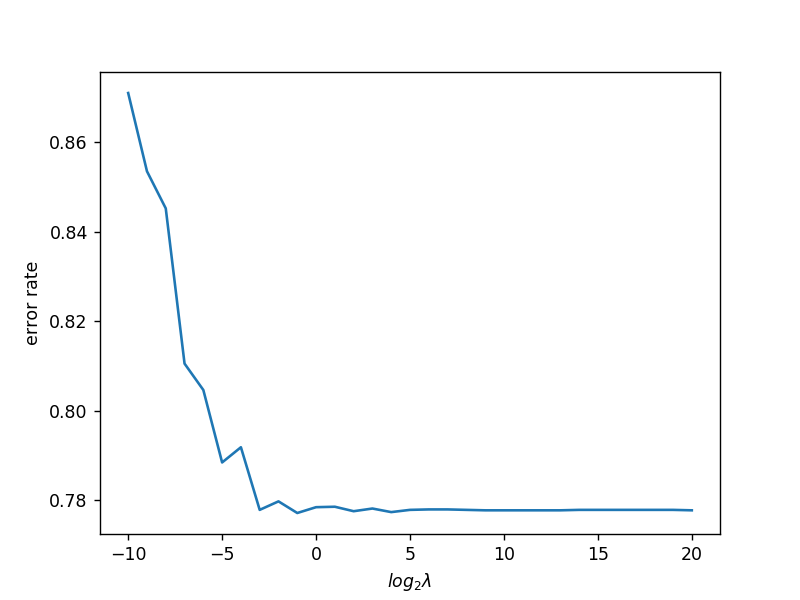

In [16]:
temp = np.zeros(S.shape[0])
temp[0:60] = S[0:60]
s = np.diag(temp)

errorRate = np.zeros(31)
imagesReduced = U@s@VT
k = np.arange(-10,21, dtype=float)

for i in range(31):
    lmda = 2**(k[i])
    w_2 = np.linalg.inv(imagesReduced.transpose()@imagesReduced+lmda*np.identity(rowNum*colNum))@imagesReduced.transpose()@labels
    
    labelsHat = np.around(np.clip(imagesT@w_2, 0, 9))
    errorRate[i] = 1 - np.sum(labelsHat == labelsT) / numT

fig = plt.figure()
plt.plot(k, errorRate)
plt.xlabel('$log_2\lambda$')
plt.ylabel('error rate')
plt.show()

# Using rank=80 approximation and tuning the parameter $\lambda=2^k, k = -4, -3, ..., 3, 4$

<IPython.core.display.Javascript object>


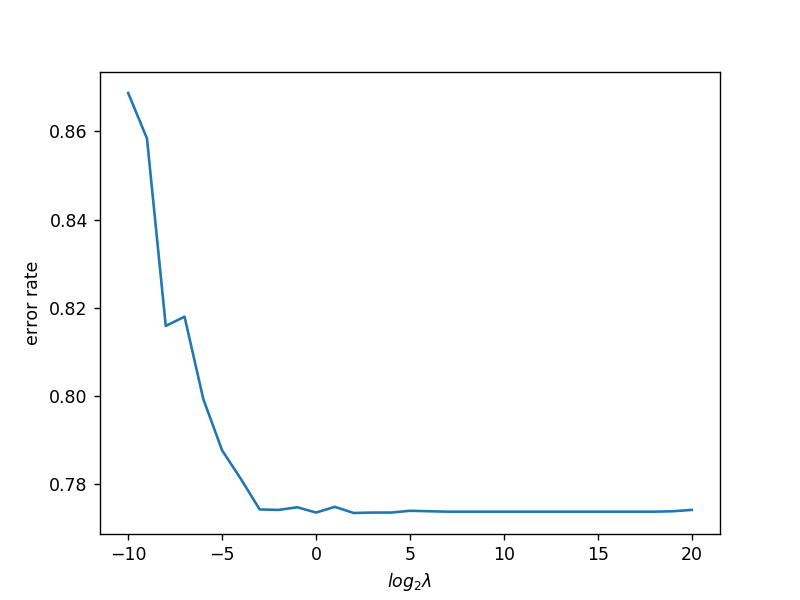

In [17]:
temp = np.zeros(S.shape[0])
temp[0:80] = S[0:80]
s = np.diag(temp)

errorRate = np.zeros(31)
imagesReduced = U@s@VT
k = np.arange(-10,21, dtype=float)

for i in range(31):
    lmda = 2**(k[i])
    w_2 = np.linalg.inv(imagesReduced.transpose()@imagesReduced+lmda*np.identity(rowNum*colNum))@imagesReduced.transpose()@labels
    
    labelsHat = np.around(np.clip(imagesT@w_2, 0, 9))
    errorRate[i] = 1 - np.sum(labelsHat == labelsT) / numT

fig = plt.figure()
plt.plot(k, errorRate)
plt.xlabel('$log_2\lambda$')
plt.ylabel('error rate')
plt.show()

# search on two dimensions, $\lambda$ and \#($\sigma_i$)

In [18]:
errorRate = np.zeros((20, 21))
k = np.arange(-10,11, dtype=float)

for i in range(20):
    temp = np.zeros(S.shape[0])
    temp[0:(i+1)*5] = S[0:(i+1)*5]
    s = np.diag(temp)
    imagesReduced = U@s@VT
    for j in range(21):
        lmda = 2**(k[j])
        w = np.linalg.inv(imagesReduced.transpose()@imagesReduced+lmda*np.identity(rowNum*colNum))@imagesReduced.transpose()@labels
        
        labelsHat = np.around(np.clip(imagesT@w, 0, 9))
        errorRate[i][j] = 1 - np.sum(labelsHat == labelsT) / numT

<IPython.core.display.Javascript object>


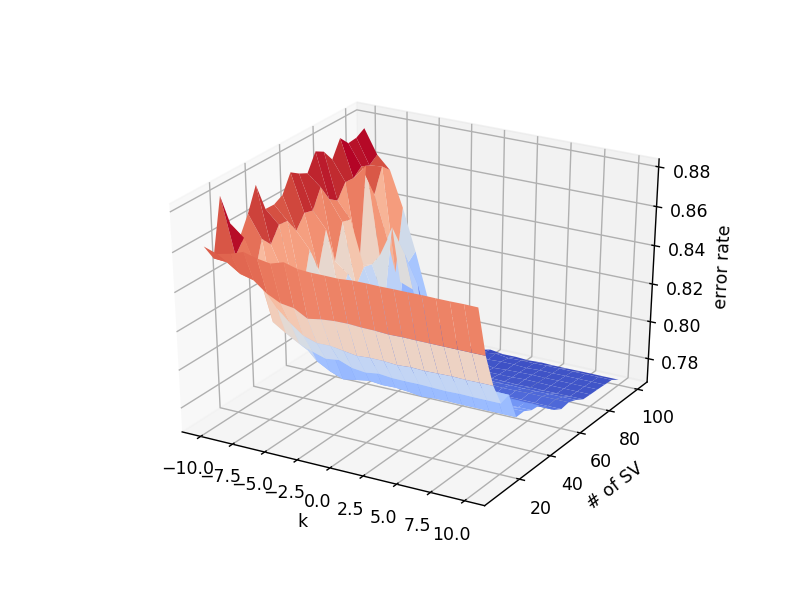

In [19]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

X, Y = np.meshgrid(k, np.arange(1, 21)*5)
Z = errorRate

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)

ax.set_xlabel('k')
ax.set_ylabel('# of SV')
ax.set_zlabel('error rate')
plt.show()

In [20]:
i = np.argmin(errorRate)
print('best k: ', k[i%errorRate.shape[1]])
print('best # of SV: ',(1 + i//errorRate.shape[1])*5)

best k:  -1.0
best # of SV:  100


# add a constant feature

<IPython.core.display.Javascript object>


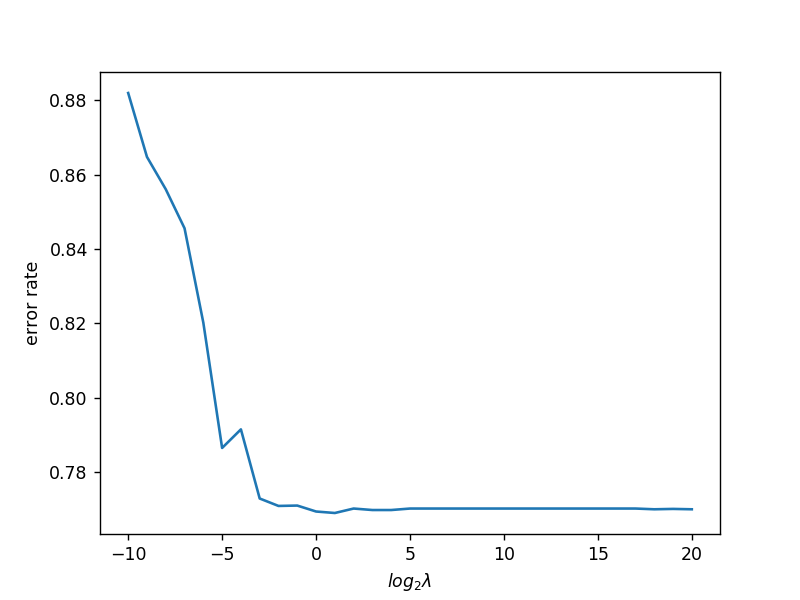

In [49]:
imagesExtend = np.hstack((images, np.ones(images.shape[0]).reshape(images.shape[0], 1)))
imagesTExtend = np.hstack((imagesT, np.ones(imagesT.shape[0]).reshape(imagesT.shape[0], 1)))
U1, S1, VT1 = np.linalg.svd(imagesExtend, full_matrices=False)

temp = np.zeros(S1.shape[0])
temp[0:100] = S1[0:100]
s1 = np.diag(temp)

errorRate1 = np.zeros(31)
imagesReduced1 = U1@s1@VT1
k = np.arange(-10,21, dtype=float)

for i in range(31):
    lmda = 2**(k[i])
    w_2 = np.linalg.inv(imagesReduced1.transpose()@imagesReduced1+lmda*np.identity(rowNum*colNum+1))@imagesReduced1.transpose()@labels
    
    labelsHat = np.around(np.clip(imagesTExtend@w_2, 0, 9))
    errorRate1[i] = 1 - np.sum(labelsHat == labelsT) / numT

fig = plt.figure()
plt.plot(k, errorRate1)
plt.xlabel('$log_2\lambda$')
plt.ylabel('error rate')
plt.show()

# cross validation: divide the 60,000 training images into 6 groups. 5 groups are used for training, remaining one is used for selecting the value of the tuning parameter $\lambda$.

In [57]:
index = list(range(60000))
groups = [index[0:10000], index[10000:20000], index[20000:30000], index[30000:40000], index[40000:50000], index[50000:60000]]

k = np.arange(-10,21, dtype=float)

trainImages = images[0:50000, :]
trainLabels = labels[0:50000]
selectImages = images[50000:60000, :]
selectLabels = labels[50000:60000]

errorRate = np.zeros(k.shape[0])
errorRateFinal = np.zeros(k.shape[0])

for i in range(k.shape[0]):
    lmda = 2**(k[i])
    w = np.linalg.inv(trainImages.T@trainImages + lmda*np.identity(rowNum*colNum))@trainImages.T@trainLabels
    labelsHat = np.around(np.clip(selectImages@w, 0, 9))
    errorRate[i] = 1 - np.sum(labelsHat == selectLabels) / selectLabels.shape[0]
    
    labelsHat = np.around(np.clip(imagesT@w, 0, 9))
    errorRateFinal[i] = 1 - np.sum(labelsHat == labelsT) / numT

print('final error rate: ', errorRateFinal[np.argmin(errorRate)])


final error rate:  0.7437


<IPython.core.display.Javascript object>


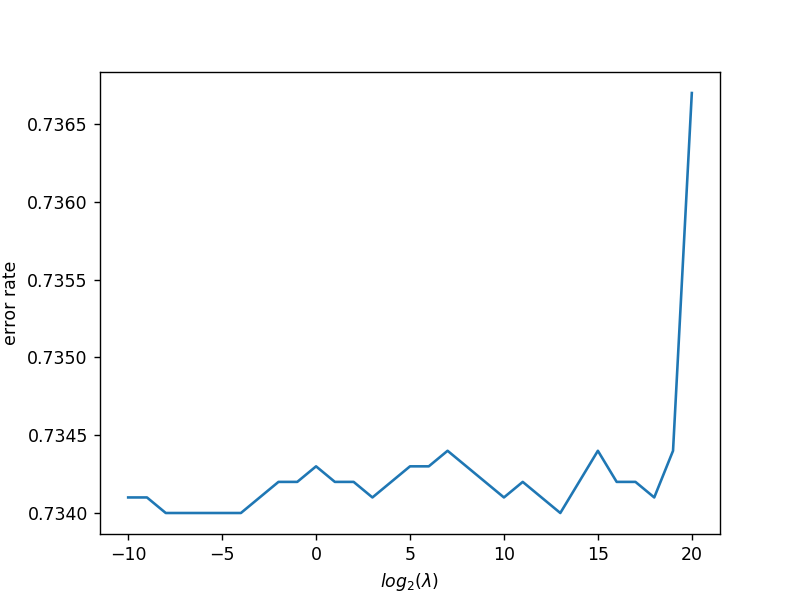

In [56]:
fig = plt.figure()
plt.plot(k, errorRate)
plt.xlabel('$log_2(\lambda)$')
plt.ylabel('error rate')
plt.show()

# train a classifier for each digit

In [21]:
# to record the weight for each digit
W = np.zeros((rowNum*colNum, 10))

for j in range(10):
    # data set for training
    trainLa = np.copy(labels[0:50000])
    l1 = np.argwhere(trainLa==j)
    l2 = np.argwhere(trainLa!=j)
    trainLa[l1] = +1
    trainLa[l2] = -1
    trainLa = trainLa.reshape(50000,1)
    
    trainImages = images[0:50000, :]
    
    # data set for tuning the parameter
    selectLa = np.copy(labels[50000:60000])
    l1 = np.argwhere(selectLa==j)
    l2 = np.argwhere(selectLa!=j)
    selectLa[l1] = +1
    selectLa[l2] = -1
    selectLa = selectLa.reshape(10000,1)
    
    selectImages = images[50000:60000, :]
    
    # data set for final test
    testLa = np.copy(labelsT)
    l1 = np.argwhere(testLa==j)
    l2 = np.argwhere(testLa!=j)
    testLa[l1] = +1
    testLa[l2] = -1
    testLa = testLa.reshape(10000,1)
    
    errorRate = np.zeros(k.shape[0])
    errorRateFinal = np.zeros(k.shape[0])

    X2 = ridge_solve(trainImages, trainLa, 2**(k))
    
    for i in range(k.shape[0]):
        w = X2[:, i:i+1]
        labelsHat = np.sign(selectImages@w)
        errorRate[i] = 1 - np.sum(labelsHat == selectLa) / selectLa.shape[0]

        labelsHat = np.sign(imagesT@w)
        errorRateFinal[i] = 1 - np.sum(labelsHat == testLa) / numT

    W[:,j] = X2[:, np.argmin(errorRate)]
    print('final error rate of ', j, 'is: ', errorRateFinal[np.argmin(errorRate)])

final error rate of  0 is:  0.012800000000000034
final error rate of  1 is:  0.015100000000000002
final error rate of  2 is:  0.03820000000000001
final error rate of  3 is:  0.04279999999999995
final error rate of  4 is:  0.03080000000000005
final error rate of  5 is:  0.051000000000000045
final error rate of  6 is:  0.02629999999999999
final error rate of  7 is:  0.029900000000000038
final error rate of  8 is:  0.06840000000000002
final error rate of  9 is:  0.055400000000000005


In [22]:
labelsHat = imagesT@W
labelsHat = np.absolute(labelsHat - np.ones(labelsHat.shape))
labelsHat = np.argmin(labelsHat, axis=1).reshape(10000,1)
print('error rate: ', 1- np.sum(labelsHat.flatten() == labelsT) / numT)

error rate:  0.1461


<IPython.core.display.Javascript object>


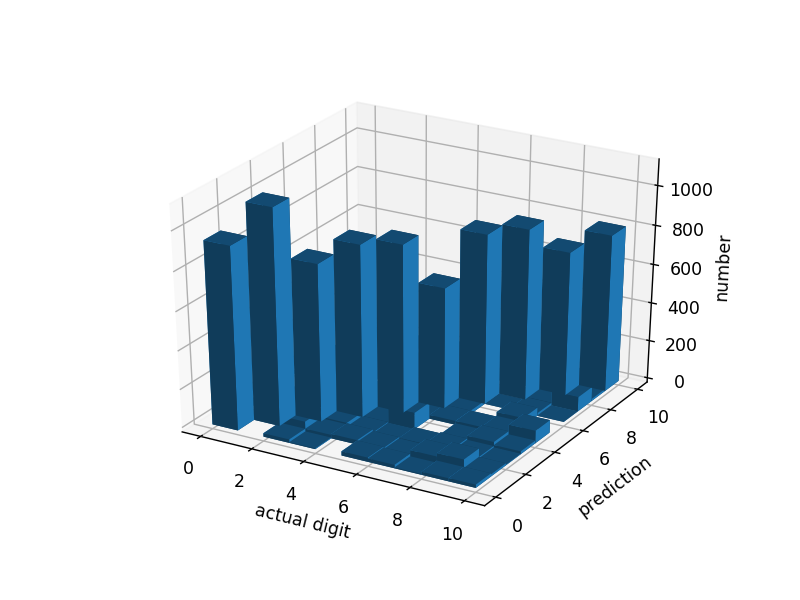

In [26]:
from mpl_toolkits.mplot3d import Axes3D

unique, counts = np.unique(np.hstack((labelsT.reshape(10000,1), labelsHat)), axis=0, return_counts=True)
#print(np.hstack((unique, counts.reshape(87,1))).astype(int))

fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')

x3 = unique[:,0]
y3 = unique[:,1]
z3 = np.zeros(counts.shape[0])

dx = np.ones(counts.shape[0])
dy = np.ones(counts.shape[0])
dz = counts

ax1.bar3d(x3, y3, z3, dx, dy, dz)


ax1.set_xlabel('actual digit')
ax1.set_ylabel('prediction')
ax1.set_zlabel('number')

plt.show()

<IPython.core.display.Javascript object>


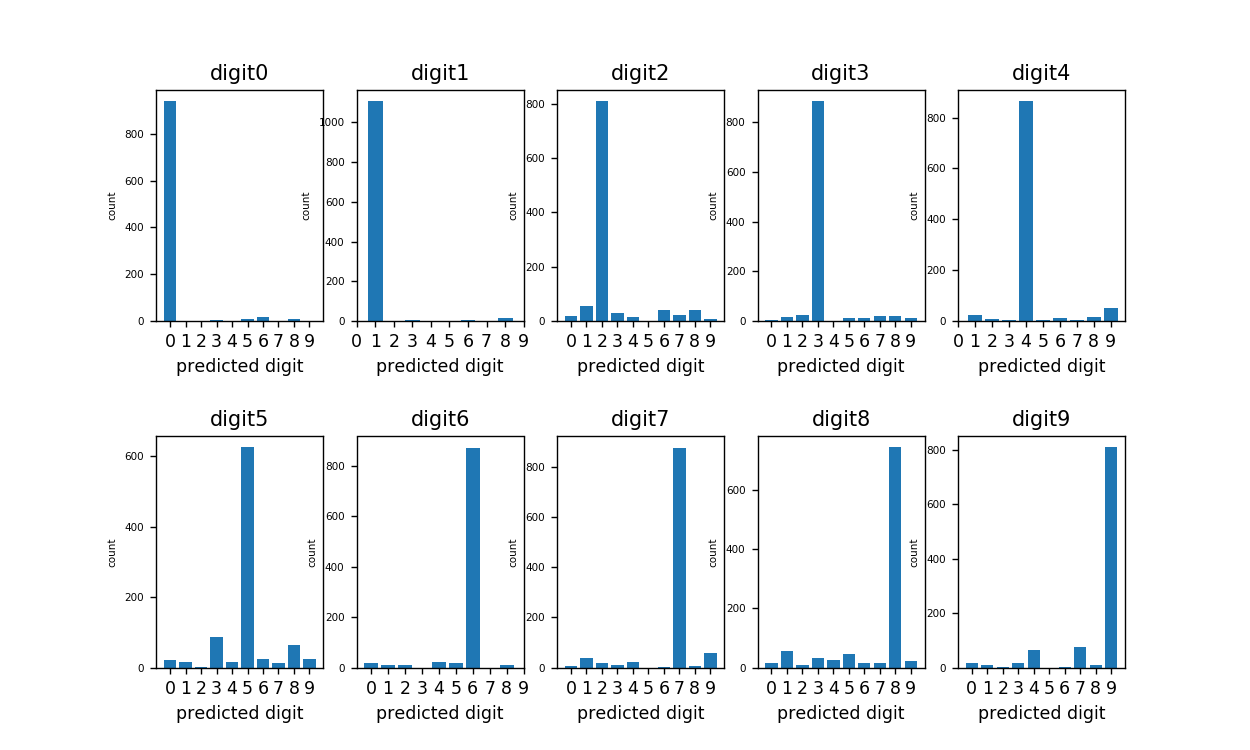

In [27]:
fig = plt.figure(figsize=(10, 6))
plt.subplots_adjust(hspace=0.5)
for i in range(10):
    ax = fig.add_subplot(2,5,i+1)
    actual = unique[:,0]
    prediction = unique[:,1]
    ax.bar(prediction[actual==i], counts[actual==i])
    plt.xticks(np.arange(0,10))
    plt.yticks(fontsize=6)
    ax.set_xlabel('predicted digit')
    ax.set_ylabel('count', fontsize=6)
    ax.title.set_text('digit'+ str(i))
plt.show()

<IPython.core.display.Javascript object>


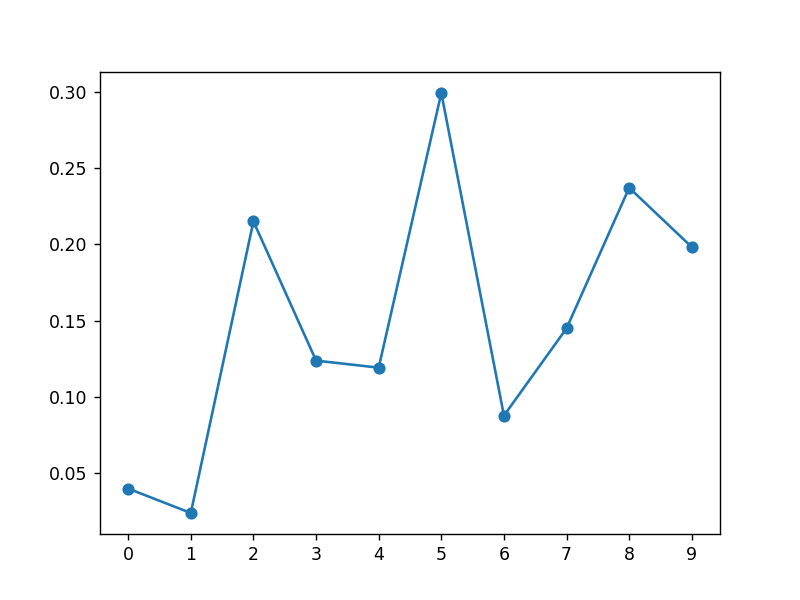

In [28]:
errorRate = []
for i in range(10):
    l = np.argwhere(unique[:, 0]==i)
    temp1 = counts[l.flatten()]
    total = np.sum(temp1)
    temp2 = unique[l.flatten(), :][:,1]
    error = total - temp1[temp2==i]
    errorRate.append(error/total)

fig = plt.figure()
plt.plot(np.arange(0,10), errorRate, marker='o')
plt.xticks(np.arange(0,10))
plt.show()